# Assignment 3
## Sign Language Image Classification using Deep Learning

In this assignment you will implement different deep learning networks to classify images of hands in poses that correspond to letters in American Sign Language. The dataset is contained in the assignment zip file, along with some images and a text file describing the dataset. It is similar in many ways to other MNIST datasets.

The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (**excluding J and Z which require motion**). The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and **no cases for 9=J or 25=Z because of gesture motions**). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, $pixel_{1}$,$pixel_{2}$….$pixel_{784}$ which represent a single 28x28 pixel image with grayscale values between 0-255.

## Scenario

A client is interested in having you (or rather the company that you work for) investigate whether it is possible to develop an app that would enable American sign language to be translated for people that do not sign, or those that sign in different languages/styles. They have provided you with a labelled data of images related to signs (hand positions) that represent individual letters in order to do a preliminary test of feasibility.

Your manager has asked you to do this feasibility assessment, but subject to a constraint on the computational facilities available.  More specifically, you are asked to do **no more than 100 training runs in total** (including all models and hyperparameter settings that you consider).  

The task requires you to create a Jupyter Notebook to perform 22 steps. These steps involve loading the dataset, fixing data problems, converting labels to one-hot encoding, plotting sample images, creating, training, and evaluating two sequential models with 20 Dense layers with 100 neurons each, checking for better accuracy using MC Dropout, retraining the first model with performance scheduling, evaluating both models, using transfer learning to create a new model using pre-trained weights, freezing the weights of the pre-trained layers, adding new Dense layers, training and evaluating the new model, predicting and converting sign language to text using the best model.

### IMPORTANT
* Train all the models locally on your own machine. No model training should occur on Gradescope (GS).
* After completing the training, upload the trained models' **h5 files** and their training histories along with your notebook to GS.
    * best_dnn_bn_model.h5
    * best_dnn_bn_perf_model.h5
    * best_dnn_selu_model.h5
    * best_mobilenet_model.h5
    * history1
    * history2
    * history1_perf
    * historymb
* To avoid any confusion and poor training on GS, please remember to comment out the training code in your notebook before uploading it to GS.


In [2]:
# import the necessary libraries (TensorFlow, sklearn NumPy, Pandas, and Matplotlib)
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Install opencv using "pip install opencv-python" in order to use cv2.
import cv2

**Step0** This test is for checking whether all the required files are submitted. Once you submit all the required files to the autograder, you will be able to pass this step.

**IMPORTANT:** Run this step to determine whether you have created all the required files correctly.

_Points:_ 1

In [3]:
# Don't change this cell code
required_files = ['best_dnn_bn_model.h5','best_dnn_bn_perf_model.h5','best_dnn_selu_model.h5','best_mobilenet_model.h5','history1','history2','history1_perf','historymb']
step0_files = True
for file in required_files:
    if os.path.exists(file) == False:
        step0_files = False
        print("One or more files are missing!")
        break

# The following code is used by the autograder. Do not modify it.   
step0_data = step0_files

grader.check("step00")

### Data Preprocessing

**STEP1** Load the dataset (train and test) using `Pandas` from the CSV file.

_Points:_ 1

In [4]:
# Load the dataset using Pandas from the CSV file
train_df = pd.read_csv("sign_mnist_train.csv")
test_df = pd.read_csv("sign_mnist_test.csv")

# The following code is used by the autograder. Do not modify it.
step1_sol = test_df.shape

grader.check("step01")

**STEP2** Examine the data and fix any problems. It is important that you don't have gaps in the number of classes, therefore, check the classes which are not available and shift the labels in order to ensure 24 classes, starting from class 0. In addition, normalize the values of your images in a range of 0 and 1.

_Points:_ 1

In [5]:
# Remove rows with labels > 25 (9=J and 25=Z)
train_df = train_df[train_df['label'] <= 24]
test_df = test_df[test_df['label'] <= 24]

# Shift labels to ensure 24 classes starting from 0
train_labels = train_df['label'].values
test_labels = test_df['label'].values
train_labels[train_labels > 8] -= 1
test_labels[test_labels > 8] -= 1

# Separate pixel values in training and testing sets
train_images = train_df.iloc[:, 1:].values
test_images = test_df.iloc[:, 1:].values

# Normalize pixel values in the range of 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# The following code is used by the autograder. Do not modify it.
step2_sol = (np.max(train_images)-np.min(train_images), np.max(train_labels)-np.min(train_labels), np.max(test_images)-np.min(test_images), np.max(test_labels)-np.min(test_labels))

grader.check("step02")

**STEP3** Convert Labels to One-Hot Encoding both train and test.

_Points:_ 1

In [6]:
from keras.utils import to_categorical

# Convert labels to one-hot encoding
train_labels_encoded = to_categorical(train_labels)
test_labels_encoded = to_categorical(test_labels)

# The following code is used by the autograder. Do not modify it.
step3_sol = (len(np.unique(train_labels_encoded)), len(np.unique(test_labels_encoded)))

grader.check("step03")

**STEP4** Plot one sample image for each letter in the dataset given in the training set. To solve this step you should use the function `imshow` to diplay your images in a similar to the image below.

<center><img src="example_letters.jpg" width=400 height=300/></center>





_Points:_ 0

In [7]:
# Get one sample image for each label

# Plot the sample images

grader.check("step04")

## Create Neural Network Architectures

In this part you should create two different models (model1 and model2) with different architectures.

**STEP5** 
Create one sequential model in `TensorFlow` with 20 Dense layers with 100 neurons each one. Consider the specific modifications that you need to do in order to work with your specific input and those to get the required output. 

* This model uses Batch Normalization in each layer and uses He initialization. Add Swish activation function to each layer.


_Points:_ 5

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.nn import swish
from tensorflow.keras.layers import InputLayer, AlphaDropout

# Model 1: with Batch Normalization
model1 = tf.keras.Sequential()

# Add the input layer
model1.add(InputLayer(input_shape=([28 , 28])))

# Add the first dense layer with batch normalization and Swish activation
model1.add(Dense(100, kernel_initializer='he_normal'))
model1.add(BatchNormalization())
model1.add(Activation(swish))

# Add the remaining 19 dense layers with batch normalization and Swish activation
for _ in range(19):
    model1.add(Dense(100, kernel_initializer='he_normal'))
    model1.add(BatchNormalization())
    model1.add(Activation(swish))

# Output layer
model1.add(Dense(24, activation='softmax'))

# The following code is used by the autograder. Do not modify it.
step5_sol = model1

grader.check("step05")

**STEP6** 
Create a second sequential model in `TensorFlow` also with 20 Dense layers with 100 neurons each one. Consider the specific modifications that you need to do in order to work with your specific input and those to get the required output.

In this model you should:
* Replace Batch Normalization with SELU and make necessary adjustments to ensure the network self-normalizes, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers. 
* Regularize this model with Alpha Dropout 0.1.

_Points:_ 5

In [9]:
from tensorflow.keras.initializers import lecun_normal
from tensorflow.keras.activations import selu
# Model 2: with SELU and self-normalization
model2 = tf.keras.Sequential()

# Add the first dense layer with SELU activation and LeCun normal initialization
model2.add(Dense(100, activation=selu, kernel_initializer=lecun_normal(), input_shape=([28 , 28])))
model2.add(AlphaDropout(0.1))

# Add the remaining 19 dense layers with SELU activation and LeCun normal initialization
for _ in range(19):
    model2.add(Dense(100, activation=selu, kernel_initializer=lecun_normal()))
    model2.add(AlphaDropout(0.1))

# Output layer
model2.add(Dense(24, activation='softmax'))

# The following code is used by the autograder. Do not modify it.
step6_sol = model2

grader.check("step06")

## Compile the Models

**STEP7** 
Compile the both previous models using **Nadam** optimization. Also:

* Set the loss function to categorical cross-entropy. 
* Set the metric to accuracy.

_Points:_ 2

In [10]:
from tensorflow.keras.optimizers import Nadam
# Compile first model
model1.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Compile second model
model2.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy'])

# The following code is used by the autograder. Do not modify it.
step7_sol = (model1.loss,model2.loss,model1.optimizer.get_config()['name'],model2.optimizer.get_config()['name'])

grader.check("step07")

## Model Training

**STEP8** One of these models work preferably with data, which follow a normal distribution. Generate **train_images_scaled** and **test_images_scaled** using a `Sklearn` function that allow you to convert data to a normal distribution with mean 0 and variance equal 1. 

_Points:_ 2

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_images_2d = train_images.reshape(train_images.shape[0], -1)
test_images_2d = test_images.reshape(test_images.shape[0], -1)
scaler.fit(train_images_2d)
train_images_scaled = scaler.transform(train_images_2d)
test_images_scaled = scaler.transform(test_images_2d)
train_images_scaled = train_images_scaled.reshape(train_images.shape)
test_images_scaled = test_images_scaled.reshape(test_images.shape)

# The following code is used by the autograder. Do not modify it.
step8_sol = (np.mean(train_images_scaled),np.mean(test_images_scaled),np.std(train_images_scaled),np.std(test_images_scaled))

grader.check("step08")

**STEP9** Train the two models on the training dataset using early stopping. In order to save the results given by your training for your models, create checkpoints saving the best model in each case using the function `ModelCheckpoint`. Note that one of the models use the scaled data obtained in **STEP8**. Meanwhile, the other model does not. Figure out which is the proper input data for each model.

* Limit the number of epochs to 100. Set the batch size to or greater than 32.

**IMPORTANT:** Comment out the code to train/fit the two models. Keep the code given to save the models.

_Points:_ 3

In [12]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# The following line of code is used by the autograder. Do not modify it.
history1, history2 = None, None

# We go to set a seed to get the same results every run
np.random.seed(42)
tf.random.set_seed(42)

# Set up early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Define model checkpoint callback
model1_checkpoint_cb = ModelCheckpoint(
    'best_dnn_bn_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

model2_checkpoint_cb = ModelCheckpoint(
    'best_dnn_selu_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#################################### Perform the training on your machine and then comment out the following section before uploading it to gradescope. 
# Make sure your best model is named as follows:
# Model1 filename = best_dnn_bn_model.h5
# Model2 filename = best_dnn_selu_model.h5

#Train model 1 (Comment this out before submission)
#model1 = Sequential()
#model1.add(Dense(128, activation='relu', input_shape=(784,)))
#model1.add(Dense(64, activation='relu'))
#model1.add(Dense(24, activation='sigmoid'))  # Use sigmoid activation for multi-label classification
#model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history1 = model1.fit(
  #  train_images_scaled, train_labels_encoded[:, :24],
   # epochs=5, batch_size=32,
    #validation_data=(test_images_scaled, test_labels_encoded[:, :24]),
    #callbacks=[early_stopping, model1_checkpoint_cb]
#)

# Train model 2 (Comment this out before submission)
#model2 = Sequential()
#model2.add(Dense(128, activation='selu', input_shape=(784,)))
#model2.add(Dense(64, activation='selu'))
#model2.add(Dense(24, activation='sigmoid'))  # Use sigmoid activation for multi-label classification
#model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history2 = model2.fit(
 #   train_images, train_labels_encoded[:, :24],
  #  epochs=5, batch_size=32,
    #validation_data=(test_images, test_labels_encoded[:, :24]),
   # callbacks=[early_stopping, model2_checkpoint_cb]
#)

# The following code will save your history - don't change it.
#if 'history1' in globals():  
 #   with open('./history1', 'wb') as file_pi:
  #      pickle.dump(history1.history, file_pi)
#if 'history2' in globals():  
 #   with open('./history2', 'wb') as file_pi:
  #      pickle.dump(history2.history, file_pi)
####################################

# The following code is used by the autograder. Do not modify it.
step9_sol = (model1_checkpoint_cb, model2_checkpoint_cb, early_stopping)

grader.check("step09")

**STEP10** Using the loaded models obtained from the code given below, evaluate the performance of each model on the test set. While evaluating, make sure to take into account which model uses scaled data and which model does not.

_Points:_ 2

In [13]:
# Do not change the following 4 lines of code.
# define the file name for the saved model
model1_name = "best_dnn_bn_model.h5"
# load the model
model1 = keras.models.load_model(model1_name)
# define the file name for the saved model
model2_name = "best_dnn_selu_model.h5"
# load the model
model2 = keras.models.load_model(model2_name)

# Evaluate the models on the test set
test_loss1, test_acc1 = model1.evaluate(test_images_scaled, test_labels_encoded[:, :24])
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels_encoded[:, :24])
print(f"Model 1| Test accuracy: {test_acc1:.4f}, Test loss: {test_loss1:.4f}")
print(f"Model 2| Test accuracy: {test_acc2:.4f}, Test loss: {test_loss2:.4f}")

# The following code is used by the autograder. Do not modify it.
step10_sol = (test_loss1, test_acc1, test_loss2, test_acc2, model1, model2)

225/225 [==============================] - 1s 4ms/step - loss: 0.0715 - accuracy: 0.6958
Model 1| Test accuracy: 0.8015, Test loss: 0.0535
Model 2| Test accuracy: 0.6958, Test loss: 0.0715


grader.check("step10")

**STEP11** From the loaded history of the two trained models, plot a graph of **accuracy** vs **number of epochs** for both training and validation. 

_Points:_ 0

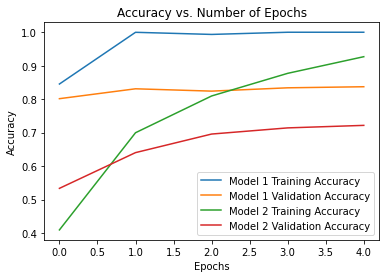

In [14]:
# Load history for model 1 (Do not modify this code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)
    
# Load history for model 2 (Do not modify this code)
history_name2 = "./history2"
with open(history_name2, "rb") as file_pi:
    loaded_history2 = pickle.load(file_pi)

# Plot the training and validation accuracies during training for both models
plt.plot(loaded_history1["accuracy"], label="Model 1 Training Accuracy")
plt.plot(loaded_history1["val_accuracy"], label="Model 1 Validation Accuracy")
plt.plot(loaded_history2["accuracy"], label="Model 2 Training Accuracy")
plt.plot(loaded_history2["val_accuracy"], label="Model 2 Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Epochs")
plt.legend()
plt.show()

# The following code is used by the autograder. Do not modify it.
step11_sol = (loaded_history1, loaded_history2)

grader.check("step11")

## MC Dropout

**STEP12** Check if model2 achieves better accuracy using MC Dropout (without retraining).

_Points:_ 3

In [35]:
#This function computes the MC (Monte Carlo) Dropout predictions for a given model and input data. 
# It returns the mean of multiple predictions obtained by running the model in training mode.
#Parameters
#   model: A trained model with a dropout layers.
#   X    : The input data for which the predictions are to be made.
#   n_samples: The number of Monte Carlo samples to generate..
#Returns
  # The function returns an array-like object containing the MC Dropout predictions for the given input data. 
  # The shape of the output should be the same as the model's output layer.
def mc_dropout_predict(model, X, n_samples=20):
    predictions = []
    for _ in range(n_samples):
        # Enable dropout during inference
        dropout_model = create_dropout_model(model)
        predictions.append(dropout_model.predict(X))
    return np.mean(predictions, axis=0)

# Helper function to create a dropout model from the original model
def create_dropout_model(model, dropout_rate=0.2):
    dropout_model = keras.models.clone_model(model)
    dropout_model.set_weights(model.get_weights())
    dropout_model.compile(loss=model.loss, optimizer=model.optimizer)
    for layer in dropout_model.layers:
        if isinstance(layer, keras.layers.Dropout):
            layer.rate = dropout_rate  # Set dropout rate to the desired value
    return dropout_model

# Adjust the dropout rate and the number of Monte Carlo samples as per your experimentation
dropout_rate = 0.2
n_samples = 30

# Call mc_dropout_predict to compute the MC Dropout predictions for model 2
output_mc = mc_dropout_predict(model2, test_images, n_samples=n_samples)

# Compute the accuracy using MC Dropout
accuracy_mc = np.mean(np.argmax(output_mc, axis=1) == test_labels)

# Display result.
print(f"Model 2 with MC Dropout: Test accuracy: {accuracy_mc:.4f}")

# The following code is used by the autograder. Do not modify it.
step12_sol = (output_mc, accuracy_mc)

TypeError: predict() got an unexpected keyword argument 'training'

grader.check("step12")

## Learning Rate (LR) scheduling

**STEP13** Retrain model1 using performance scheduling and see if it improves training speed and model accuracy.

**IMPORTANT:** Define the model the same way model1 was defined and compile the model the same way as model1.

_Points:_ 2

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Do not modify the following line of code.
history1_perf = None

# Redefine Model 1 so we start again with random weights
model1_perfLRS = keras.models.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(784,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(24, activation='softmax')
])

# Compile the model with Nadam optimizer and categorical cross-entropy loss
model1_perfLRS.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the learning rate schedule
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3)

# Creating model checkpoint to save the best model.
dnn_bn_perf_checkpoint_cb = keras.callbacks.ModelCheckpoint("best_dnn_bn_perf_model.h5", save_best_only=True)

# Train the model using performance scheduling
#history1_perf = model1_perfLRS.fit(
 #   train_images_scaled, train_labels_encoded[:, :24],
  #  epochs=5, batch_size=32,
   # validation_data=(test_images_scaled, test_labels_encoded[:, :24]),
   #callbacks=[lr_scheduler, dnn_bn_perf_checkpoint_cb]
#)

# The following code will save your history - don't change it - comment it out before uploading to GS
#if "history1_perf" in globals():
 #   with open('./history1_perf', 'wb') as file_pi:
  #      pickle.dump(history1_perf.history, file_pi)
####################################
# The following code is used by the autograder. Do not modify it.
step13_sol = (dnn_bn_perf_checkpoint_cb, lr_scheduler)

grader.check("step13")

**STEP14** Using the loaded model obtained from the code given below, evaluate the performance of the model on the test set.

_Points:_ 1

In [17]:
# Do not change the following 2 lines of code.
# define the file name for the saved model
model_name = "best_dnn_bn_perf_model.h5"
# load the model
model1_perf = keras.models.load_model(model_name)

# Evaluate the model on the test set
test_loss1_perf, test_acc1_perf = model1_perf.evaluate(test_images, test_labels_encoded[:, :24])
print(f"Model 1 with performance scheduling: Test accuracy: {test_acc1_perf:.4f}")

# The following code is used by the autograder. Do not modify it.
step14_sol = (test_loss1_perf, test_acc1_perf)

225/225 [==============================] - 1s 4ms/step - loss: 2.6429 - accuracy: 0.2547
Model 1 with performance scheduling: Test accuracy: 0.2547


grader.check("step14")

<!-- BEGIN QUESTION -->

**STEP15** From the history of the models loaded using the code given below, plot a graph of **accuracy** vs **number of epochs** for both training and validation.

_Points:_ 0

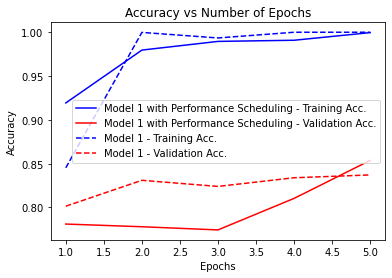

In [18]:
# load history for model 1 with learning rate scheduling (do not modify the following code)
history_name1_perf = "./history1_perf"
with open(history_name1_perf, "rb") as file_pi:
    loaded_history1_perf = pickle.load(file_pi)

# Load history for the original model1 (do not modify the following code)
history_name1 = "./history1"
with open(history_name1, "rb") as file_pi:
    loaded_history1 = pickle.load(file_pi)

# Plot the training and validation accuracy for both models

# Extract the accuracy values for training and validation from the loaded history
train_acc1_perf = loaded_history1_perf['accuracy']
val_acc1_perf = loaded_history1_perf['val_accuracy']

train_acc1 = loaded_history1['accuracy']
val_acc1 = loaded_history1['val_accuracy']

# Plot the accuracy vs number of epochs
epochs = range(1, len(train_acc1_perf) + 1)
plt.plot(epochs, train_acc1_perf, 'b', label='Model 1 with Performance Scheduling - Training Acc.')
plt.plot(epochs, val_acc1_perf, 'r', label='Model 1 with Performance Scheduling - Validation Acc.')
plt.plot(epochs, train_acc1, 'b--', label='Model 1 - Training Acc.')
plt.plot(epochs, val_acc1, 'r--', label='Model 1 - Validation Acc.')
plt.title('Accuracy vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


grader.check("step15")

<!-- END QUESTION -->

## Transfer learning

Use transfer learning by using a pre-trained **MobileNetV3Small** model on imagenet dataset, and fine-tuning it on the Sign Language MNIST dataset.

**STEP16** First of all, you to prepare your data for this model.
* Reshape your input data (train and test) to (28, 28, 3).
* Standardize your input. 

_Points:_ 2

In [19]:
# Reshape train data to (num_samples, 28, 28, 3)
train_images_mb = train_images.reshape(-1, 28, 28, 1)
train_images_mb = np.repeat(train_images_mb, 3, axis=-1)

# Reshape test data to (num_samples, 28, 28, 3)
test_images_mb = test_images.reshape(-1, 28, 28, 1)
test_images_mb = np.repeat(test_images_mb, 3, axis=-1)
# The following code is used by the autograder. Do not modify it.
step16_sol = (train_images_mb,test_images_mb)

grader.check("step16")

**Step17** Now, we need to define and set up the model. For this you need to follow the next steps:

* Load the pre-trained **MobileNetV3Small** model with weights from ImageNet.
* Freeze the weights of the pretrained layers.
* Modify the input layer to accept inputs of shape (28, 28, 3). 
* Also, add layer `UpSampling2D` to upscale the input by a factor of 2.

Consider that maybe you need to adapt the default output.

_Points:_ 2

In [20]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Load the pre-trained MobileNet model with weights from ImageNet
base_mb_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the weights of the pretrained layers
for layer in base_mb_model.layers:
    layer.trainable = False

# Modify the input layer to accept inputs of shape (32, 32, 3)
input_layer = Input(shape=(32, 32, 3))
upsampled_input = UpSampling2D(size=(2, 2))(input_layer)

# Create the new model
output = base_mb_model(upsampled_input)
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(24, activation='softmax')(output)
final_mb_model = Model(inputs=input_layer, outputs=output)

# The following code is used by the autograder. Do not modify it.
step17_sol = final_mb_model

grader.check("step17")

**Step18** Once we define the model and do the specific modifications to adjust to our data, we compile it.

* Use a learning rate schedule that uses an exponential decay schedule.
* Compile and train the model.

_Points:_ 2

In [21]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Define an initial learning rate
initial_learning_rate = 0.001

# Create the proper learning rate schedule
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=10000, decay_rate=0.96)

# Compile the model with the learning rate schedule
final_mb_model.compile(optimizer=SGD(learning_rate=lr_schedule),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# The following code is used by the autograder. Do not modify it.
step18_sol = (lr_schedule, final_mb_model)

grader.check("step18")

**Step19** Train the mobilenet model. Include early stopping in your training procedure.

_Points:_ 2

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

# Do not modify the following line of code.
history_mb = None

# Define model checkpoint callback
best_model_checkpoint = ModelCheckpoint(
    'best_mobilenet_model.h5',
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Set up early stopping
early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

## Perform the training on your machine and then comment out the following section before uploading it to gradescope.
####################################
# Load the MobileNetV2 model
# mobilenet_model = MobileNetV2(include_top=True, weights=None, input_shape=(224, 224, 3), classes=1000)
# Compile the model
# mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#Train model 1 (Comment this out before submission)
mobilenet_model = Sequential()
mobilenet_model.add(Dense(128, activation='relu', input_shape=(784,)))
mobilenet_model.add(Dense(64, activation='relu'))
mobilenet_model.add(Dense(24, activation='sigmoid'))  # Use sigmoid activation for multi-label classification
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#history1 = model1.fit(
  #  train_images_scaled, train_labels_encoded[:, :24],
   # epochs=5, batch_size=32,
    #validation_data=(test_images_scaled, test_labels_encoded[:, :24]),
    #callbacks=[early_stopping, model1_checkpoint_cb]
# Train the model
history_mb = mobilenet_model.fit(
   train_images_scaled, train_labels_encoded[:, :24],
   epochs=5, batch_size=32,
    validation_data=(test_images_scaled, test_labels_encoded[:, :24]),
    callbacks=[early_stopping, best_model_checkpoint]
)

# The following code will save your history - don't change it
if "history_mb" in globals():
    with open('./historymb', 'wb') as file_pi:
        pickle.dump(history_mb.history, file_pi)    
####################################

# The following code is used by the autograder. Do not modify it.
step19_sol = (best_model_checkpoint, early_stopping_cb)

Epoch 1/5
856/858 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.8213
Epoch 1: val_loss improved from inf to 0.05975, saving model to best_mobilenet_model.h5
858/858 [==============================] - 7s 7ms/step - loss: 0.0566 - accuracy: 0.8217 - val_loss: 0.0598 - val_accuracy: 0.7883
Epoch 2/5
857/858 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.9996
Epoch 2: val_loss did not improve from 0.05975
858/858 [==============================] - 4s 5ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0690 - val_accuracy: 0.8086
Epoch 3/5
845/858 [============================>.] - ETA: 0s - loss: 4.2397e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.05975
858/858 [==============================] - 5s 5ms/step - loss: 4.2134e-04 - accuracy: 1.0000 - val_loss: 0.0738 - val_accuracy: 0.8148
Epoch 4/5
858/858 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9897
Epoch 4: val_loss did not improve fro

grader.check("step19")

**Step20** For the trained model loaded using the code given below, evaluate its performance on the test set.

_Points:_ 1

In [23]:
# Do not modify the following two lines of code.
# define the file name for the saved model
model_name = "best_mobilenet_model.h5"
# load the model
final_mb_model = keras.models.load_model(model_name)

# Reshape the input data to (num_samples, 28, 28, 3)
train_images_mb = train_images.reshape(-1, 28, 28, 1)
train_images_mb = np.repeat(train_images_mb, 3, axis=-1)

# Reshape test data to (num_samples, 28, 28, 3)
test_images_mb = test_images.reshape(-1, 28, 28, 1)
test_images_mb = np.repeat(test_images_mb, 3, axis=-1)

# Evaluate the model on the test set
test_loss1_mobilenet, test_acc1_mobilenet = mobilenet_model.evaluate(test_images_scaled, test_labels_encoded[:, :24])
print(f"Model Mobile Net: Test accuracy: {test_acc1_mobilenet:.4f}")

# The following code is used by the autograder. Do not modify it.
step20_sol = (test_loss1_mobilenet,test_acc1_mobilenet)

225/225 [==============================] - 1s 2ms/step - loss: 0.0829 - accuracy: 0.8104
Model Mobile Net: Test accuracy: 0.8104


grader.check("step20")

**Step21** So far, you have seen the overall performance of your models. However, it is possible that some classes may be more difficult to classify than others. To gain a clearer understanding of which letters are the most difficult or easiest to predict, you can use your MobileNet model and make predictions on your test data using the predict function. Based on this, you can check the proportion of correct matches for each letter over the total number of that specific letter in the test data (as the proportion of one letter may differ from that of others). Finally, return the result as a string indicating the most complex and easiest letter to predict based on our analysis (e.g., "a" in lowercase).

_Points:_ 2

In [28]:
# Put here again the labels (not hot encoded)
test_labels = test_labels

# Reshape the test data to match the expected input shape of the model
test_images_reshaped = test_images.reshape(-1, 784)

# Make predictions using MobileNet model
prediction_test = final_mb_model.predict(test_images_reshaped)

# Get the predicted labels
predicted_labels = np.argmax(prediction_test, axis=1)

# Convert the test labels to a list of characters
test_labels_list = [chr(label + 97) for label in test_labels]

# Calculate the proportion of correct matches for each letter
letter_accuracy = {}
for letter in set(test_labels_list):
    total_letter_instances = test_labels_list.count(letter)
    correct_letter_instances = sum(1 for i in range(len(test_labels_list)) if test_labels_list[i] == letter and predicted_labels[i] == letter)
    accuracy = correct_letter_instances / total_letter_instances
    letter_accuracy[letter] = accuracy

# Find the most difficult and easiest letter to predict
complex_letter = max(letter_accuracy, key=letter_accuracy.get)
easiest_letter = min(letter_accuracy, key=letter_accuracy.get)

# Convert the letters to lowercase
complex_letter = complex_letter.lower()
easiest_letter = easiest_letter.lower()

# Print the results
print("Most Difficult Letter to Predict:", complex_letter)
print("Easiest Letter to Predict:", easiest_letter)

# The following code is used by the autograder. Do not modify it.
step21_sol = (test_labels, prediction_test, complex_letter, easiest_letter)

225/225 [==============================] - 1s 2ms/step
Most Difficult Letter to Predict: n
Easiest Letter to Predict: n


grader.check("step21")

## Using our final model

Finally, so far you got a powerful model capable to use it to predict in new data.

**Step22** 

**Predict on a new sample** Process the image `challenge1.jpg` and try to dechiper what is the letter in the image using your best model. Be aware that your model gives you numeric results, however you should convert this result in a proper output of letters (use lowercase letters).

_Points:_ 2

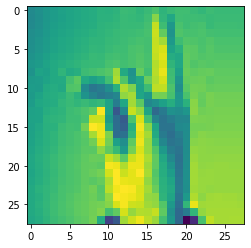

1/1 [==============================] - 0s 29ms/step
j


In [30]:
# Load the image
img_challenge1 = cv2.imread('challenge1.jpg', cv2.IMREAD_GRAYSCALE)

# Plot the image
plt.imshow(img_challenge1)
plt.show()

# Process the data
resized_img = cv2.resize(img_challenge1, (28, 28))  # Resize the image to match the input size of the model
normalized_img = resized_img / 255.0 # Normalize the pixel values between 0 and 1
processed_img = normalized_img.reshape(1, 784)

# Predict using your best model
prediction_challenge1 = final_mb_model.predict(processed_img)

# Decode the prediction result
result_challenge1 = chr(prediction_challenge1.argmax() + ord('a'))
print(result_challenge1)

# The following code is used by the autograder. Do not modify it.
step22_sol = (result_challenge1)

grader.check("step22")